In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(theme='ggplot',sharing='public',offline=True)
from IPython.display import display,HTML

In [2]:
pd.set_option('display.max_columns',10)
df = pd.read_excel('data/Metallolom.xls', 'Sheet2', parse_dates=True)
print(df.head(20))
print(df.columns)

                  time  price_1  name_2  name_4  name_5  name_6  name_7  \
0  2013-01-03 20:00:00     8400   10030    9450    7930    8110    8880   
1  2013-01-10 20:00:00     8520   10010    9510    7930    8070    9020   
2  2013-01-17 20:00:00     8440    9850    9470    7910    8230    8820   
3  2013-01-24 20:00:00     8390    9660    9400    7970    8360    8920   
4  2013-01-31 20:00:00     8220    9240    9420    7930    7640    8730   
5  2013-02-07 20:00:00     8410    9240    9400    8010    8630    8600   
6  2013-02-14 20:00:00     8340    9330    9330    8010    8630    8800   
7  2013-02-21 20:00:00     8250    9300    9340    7910    8610    8910   
8  2013-02-28 20:00:00     8270    9340    9430    7910    8500    8800   
9  2013-03-07 20:00:00     8400    9330    9400    9400    8710    8810   
10 2013-03-14 20:00:00     8360    9380    9480    9610    8710    8810   
11 2013-03-21 20:00:00     8370    9390    9500    9410    8730    8850   
12 2013-03-28 20:00:00   

/Users/irochka/opt/anaconda3/lib/python3.7/site-packages/pandas/io/excel.py:520: UserWarning:

The 'parse_dates=True' keyword of read_excel was provided without an 'index_col' keyword value.



In [3]:

labels = {
    1:'черный индекс ТрансЛом',
    2:'черный 3А, CPT ж/д Центр',
    3:'черный 3А, CPT ж/д Юг',
    4:'черный 3А, CPT ж/д Урал',
    5:'черный 3А, CPT ж/д Сибирь',
    6:'черный 3А, FCA Екатеринбург',
    7:'черный 3А, FCA Москва и МО',
    8:'черный 3А, FCA Новосибирск',
    9:'черный 3А, FCA Татарстан',
    10:'внешний рынок черный HMS 1/2 80:20, CFR Турция',
    11:'внешний рынок черный 3А, FOB Балтийское море',
    12:'внешний рынок черный 3А, FOB Черное море'
}


In [3]:
df = df.drop(['price_1','name_2','name_4','name_5','name_6',
               'name_7','name_8','name_9'],axis=1)
df.head()

,time,Median
0,2013-01-03 20:00:00,8440
1,2013-01-10 20:00:00,8305
2,2013-01-17 20:00:00,8335
3,2013-01-24 20:00:00,8375
4,2013-01-31 20:00:00,8115


In [6]:
type(df.time)

pandas.core.series.Series

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 2 columns):
time      355 non-null datetime64[ns]
Median    355 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.7 KB


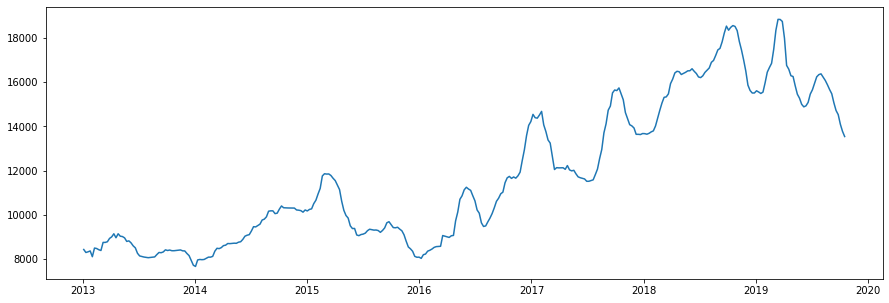

In [7]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(15,5))
plt.plot(df.time, df.Median)

In [8]:
df.columns

Index(['time', 'Median'], dtype='object')

In [9]:
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
from plotly import graph_objs as go

# инициализируем plotly
init_notebook_mode(connected = True)

# опишем функцию, которая будет визуализировать все колонки dataframe в виде line plot
def plotly_df(df, title = ''):
    data = []

   
    trace = go.Scatter(
        x = df.time,
        y = df.Median,
        mode = 'lines',
        
        )
    data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

plotly_df(df, title = 'Медиана Металлолом')

In [10]:
#импортируем библиотеку
from fbprophet import Prophet

predictions = 100

# приводим dataframe к нужному формату
data = df
data.columns = ['ds','y']

# отрезаем из обучающей выборки последние 30 точек, чтобы измерить на них качество
train_df = data[:-predictions] 
train_df.tail()

,ds,y
250,2017-10-19 21:00:00,15465
251,2017-10-26 21:00:00,15200
252,2017-11-02 21:00:00,14620
253,2017-11-09 21:00:00,14345
254,2017-11-16 21:00:00,14075


In [11]:
m = Prophet()
m.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

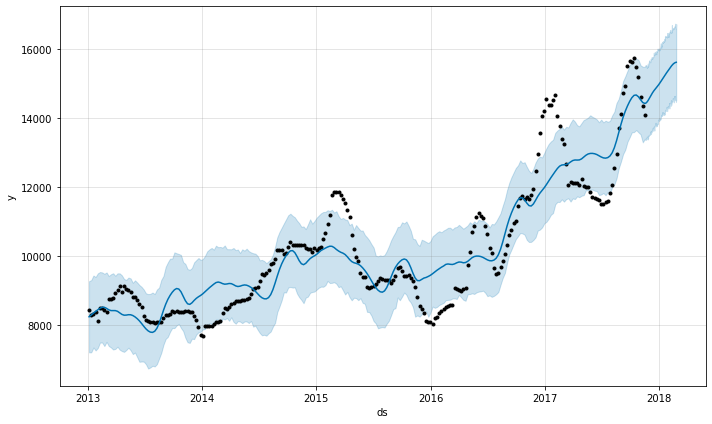

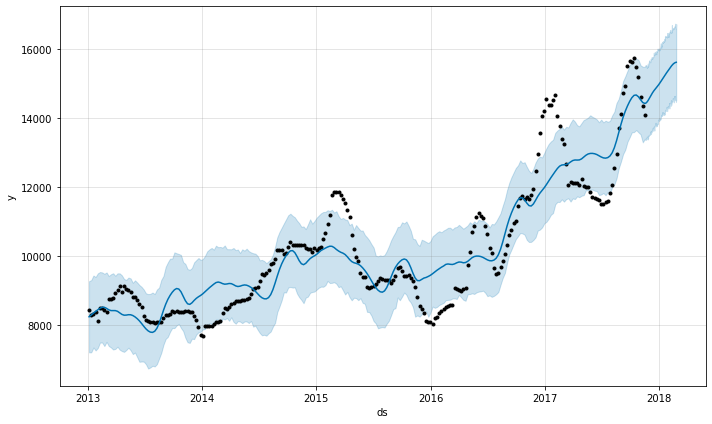

In [13]:
m.plot(forecast)

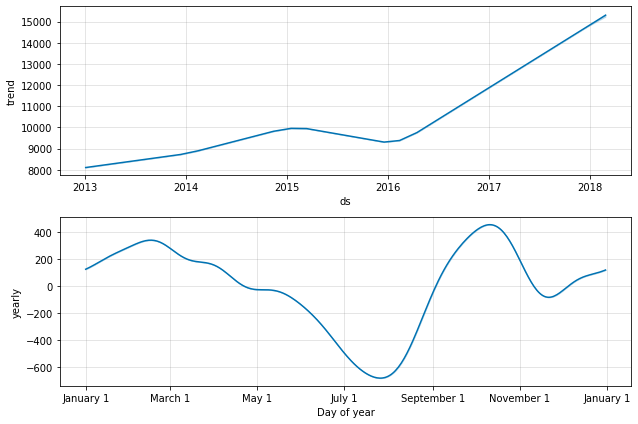

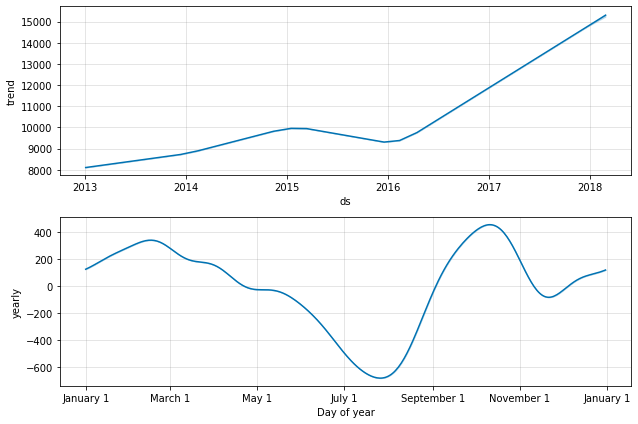

In [14]:
m.plot_components(forecast)

In [15]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [16]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 
                                   'yhat_upper']].join(df.set_index('ds'))

In [17]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print ('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print ('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE 8.735663751555839
MAE 1208.1767479474984


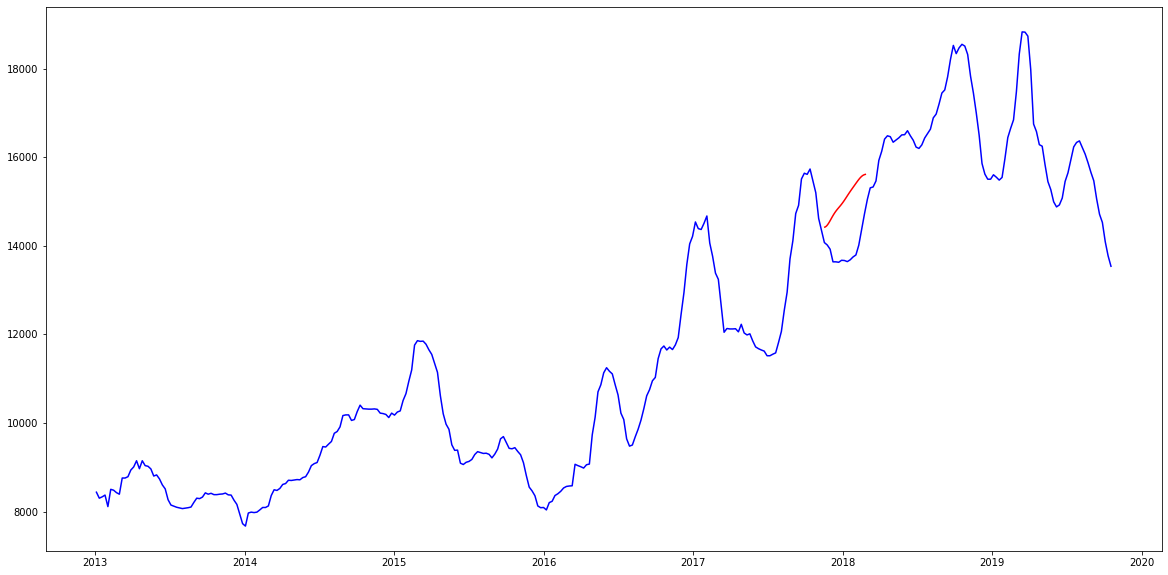

In [18]:
plt.figure(figsize=(20,10))
plt.plot(data.ds,data.y, color='blue')
plt.plot(cmp_df['yhat'][-predictions:],color='red')
plt.show()

In [19]:
from scipy import stats
import statsmodels.api as sm

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [20]:
train_df2 = train_df.copy().fillna(11806)
train_df2 = train_df2.set_index('ds')
train_df2['y'], lmbda_prophet = stats.boxcox(train_df2['y'])

train_df2.reset_index(inplace=True)

m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=5)

forecast2 = m2.predict(future2)
forecast2['yhat'] = invboxcox(forecast2.yhat, lmbda_prophet)
forecast2['yhat_lower'] = invboxcox(forecast2.yhat_lower, lmbda_prophet)
forecast2['yhat_upper'] = invboxcox(forecast2.yhat_upper, lmbda_prophet)

cmp_df2 = forecast2.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

cmp_df2['e'] = cmp_df2['y'] - cmp_df2['yhat']
cmp_df2['p'] = 100*cmp_df2['e']/cmp_df2['y']
np.mean(abs(cmp_df2[-predictions:]['p'])), np.mean(abs(cmp_df2[-predictions:]['e']))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/irochka/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log



(68.1918793253221, 8608.80456881942)

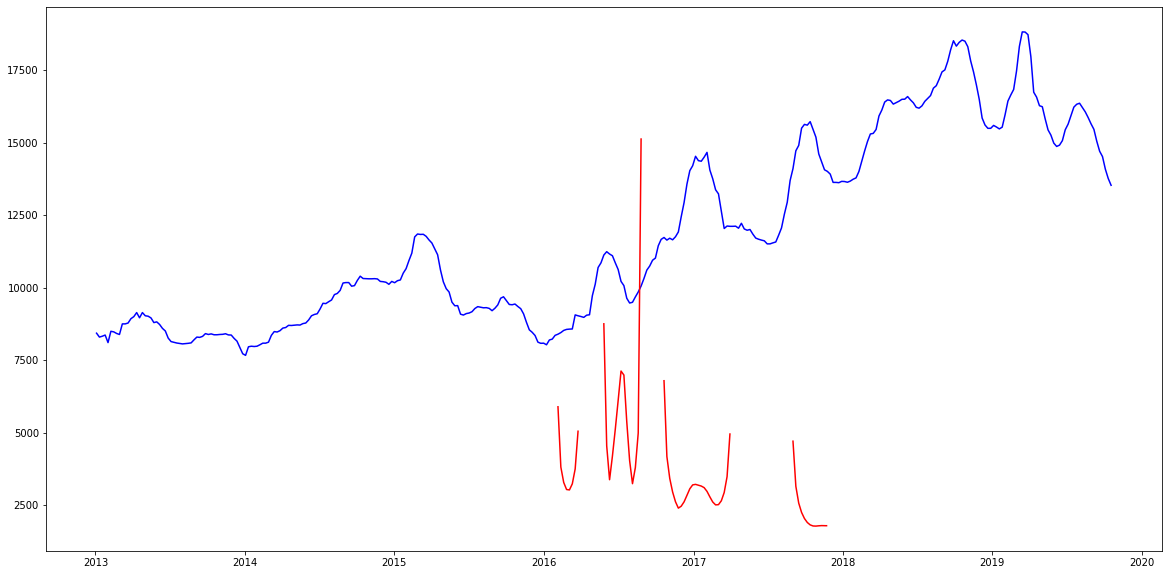

In [21]:
plt.figure(figsize=(20,10))
plt.plot(data.ds,data.y, color='blue')
plt.plot(cmp_df2['yhat'][-predictions:],color='red')
plt.show()

ARIMA


In [25]:
#%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [42]:
df.columns

Index(['ds', 'y'], dtype='object')

In [41]:
plt.figure(figsize(15,10))
#sm.tsa.seasonal_decompose(df.y).plot()  # Python написал,что сезонности какой либо не обнаружил
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.y)[1])

Критерий Дики-Фуллера: p=0.752587


<Figure size 1080x720 with 0 Axes>

Оптимальный параметр преобразования Бокса-Кокса: -0.820699
Критерий Дики-Фуллера: p=0.749530


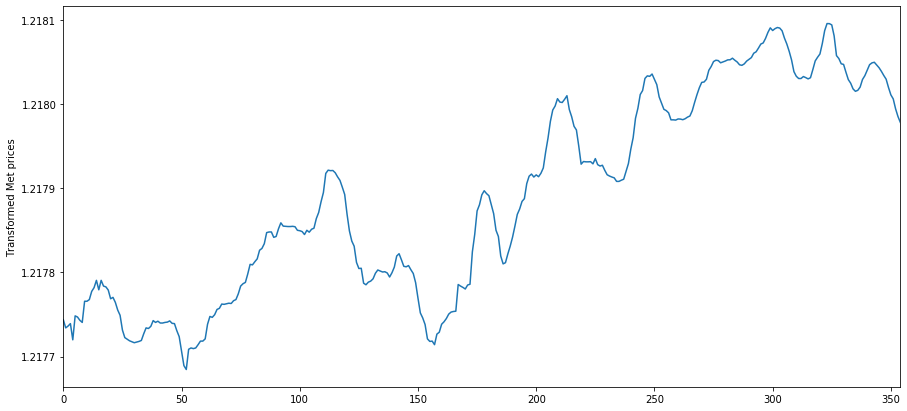

In [43]:
df['m_box'], lmbda = stats.boxcox(df.y) #Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:
plt.figure(figsize(15,7))
df['m_box'].plot()
plt.ylabel(u'Transformed Met prices')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['m_box'])[1])

In [48]:
df['m_box_diff_year'] = df.m_box - df.m_box.shift(52)
plt.figure(figsize(15,10))
#sm.tsa.seasonal_decompose(df['m_box_diff'][52:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['m_box_diff_year'][52:])[1])

Критерий Дики-Фуллера: p=0.079154


<Figure size 1080x720 with 0 Axes>

In [53]:

df['m_box_diff_week'] = df['m_box_diff_year'] - df['m_box_diff_year'].shift(1)
plt.figure(figsize(15,10))
#sm.tsa.seasonal_decompose(df.sales_box_diff_week[53:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.m_box_diff_week[53:])[1])

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

In [57]:
df['m_box_diff_month'] = df['m_box_diff_year'] - df['m_box_diff_year'].shift(4)
plt.figure(figsize(15,10))
#sm.tsa.seasonal_decompose(df.sales_box_diff_week[53:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.m_box_diff_month[56:])[1])

Критерий Дики-Фуллера: p=0.000090


<Figure size 1080x720 with 0 Axes>

In [58]:
df['m_box_diff_decade'] = df['m_box_diff_year'] - df['m_box_diff_year'].shift(12)
plt.figure(figsize(15,10))
#sm.tsa.seasonal_decompose(df.sales_box_diff_week[53:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.m_box_diff_decade[64:])[1])

Критерий Дики-Фуллера: p=0.002002


<Figure size 1080x720 with 0 Axes>

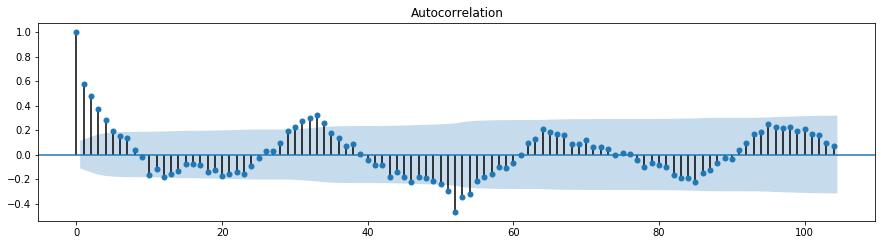

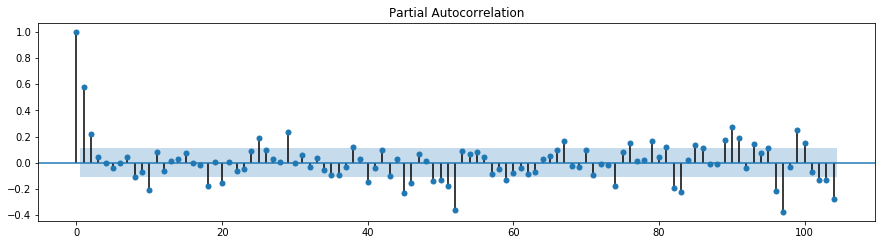

In [60]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.m_box_diff_week[53:].values.squeeze(), lags=104, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.m_box_diff_week[53:].values.squeeze(), lags=104, ax=ax)
plt.show()

Начальные приближения: Q=1, q=4, P=2 ,p=10

In [61]:
ps = range(0, 11)
d=1
qs = range(0, 5)
Ps = range(0, 3)
D=1
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

330

In [63]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.m_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 52)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

LinAlgError: Non-positive-definite forecast error covariance matrix encountered at period 58

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
for group in groups:
    plt.title('Цена Металлолома, внутр рынок')
    plt.plot(df[df.name==group]['time'],df[df.name==group]['price'])
            
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
for group in groups_vnesh:
    plt.title('Цена Металлолома, внешний рынок')
    plt.plot(vnesh_rinok[vnesh_rinok.name==group]['time'],vnesh_rinok[vnesh_rinok.name==group]['price'], label=group)
    plt.legend(loc="best")
plt.show()
plt.figure(figsize=(20,5))
for group in groups[:-3]:
    plt.title('Цена Металлолома, внутр рынок')
    plt.plot(df[df.name==group]['time'],df[df.name==group]['price'], label=group)
    plt.legend(loc="best")
plt.show()

In [25]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.ensemble import AdaBoostRegressor


# Fix needed to pandas datareader
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm


In [11]:
df_shift, y = make_forecasting_frame(df["Median"], kind="price", max_timeshift=52, rolling_direction=1)

In [12]:
df_shift.head()

,time,value,id,kind
16728,0.0,8440.0,1,price
16375,0.0,8440.0,2,price
16729,1.0,8305.0,2,price
16023,0.0,8440.0,3,price
16376,1.0,8305.0,3,price


In [24]:
df.shape

(355, 2)

In [13]:
%%capture
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                     show_warnings=False)

 'value__fft_coefficient__coeff_27__attr_"angle"'
 'value__fft_coefficient__coeff_27__attr_"imag"'
 'value__fft_coefficient__coeff_27__attr_"real"'
 'value__fft_coefficient__coeff_28__attr_"abs"'
 'value__fft_coefficient__coeff_28__attr_"angle"'
 'value__fft_coefficient__coeff_28__attr_"imag"'
 'value__fft_coefficient__coeff_28__attr_"real"'
 'value__fft_coefficient__coeff_29__attr_"abs"'
 'value__fft_coefficient__coeff_29__attr_"angle"'
 'value__fft_coefficient__coeff_29__attr_"imag"'
 'value__fft_coefficient__coeff_29__attr_"real"'
 'value__fft_coefficient__coeff_30__attr_"abs"'
 'value__fft_coefficient__coeff_30__attr_"angle"'
 'value__fft_coefficient__coeff_30__attr_"imag"'
 'value__fft_coefficient__coeff_30__attr_"real"'
 'value__fft_coefficient__coeff_31__attr_"abs"'
 'value__fft_coefficient__coeff_31__attr_"angle"'
 'value__fft_coefficient__coeff_31__attr_"imag"'
 'value__fft_coefficient__coeff_31__attr_"real"'
 'value__fft_coefficient__coeff_32__attr_"abs"'
 'value__fft_coeffic

In [14]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

(354, 794)
(354, 429)


In [15]:
# Add last value as feature
X["feature_last_value"] = y.shift(1)

# Drop first line
X = X.iloc[1:, ]
y = y.iloc[1: ]

X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40",...,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation,feature_last_value
id,,,,,,,,,,,
2,140206625.0,135.0,-1.000000,-1.000000,0.000000,...,0.000000e+00,0.0,4556.250000,1.0,8305.0
3,209678850.0,165.0,-0.524254,-0.524254,0.005294,...,0.000000e+00,0.0,3350.000000,1.0,8335.0
4,279819475.0,205.0,-0.209650,-0.406320,0.152602,...,0.000000e+00,0.0,2554.687500,1.0,8375.0
5,345672700.0,465.0,-0.503909,-0.156533,0.904281,...,-4.484543e+10,0.0,11944.000000,1.0,8115.0
6,418007725.0,855.0,-0.051301,0.082089,0.464291,...,-8.344338e+09,0.0,15020.138889,1.0,8505.0


In [20]:
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

isp = 200   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

100%|██████████| 153/153 [00:22<00:00,  6.67it/s]


In [21]:
# Dataframe of predictions and true values
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})

# Convert index to a datetime
ys.index = pd.to_datetime(ys.index)
ys.head()

,pred,true
1970-01-01 00:00:00.000000002,NaN,8335
1970-01-01 00:00:00.000000003,NaN,8375
1970-01-01 00:00:00.000000004,NaN,8115
1970-01-01 00:00:00.000000005,NaN,8505
1970-01-01 00:00:00.000000006,NaN,8485


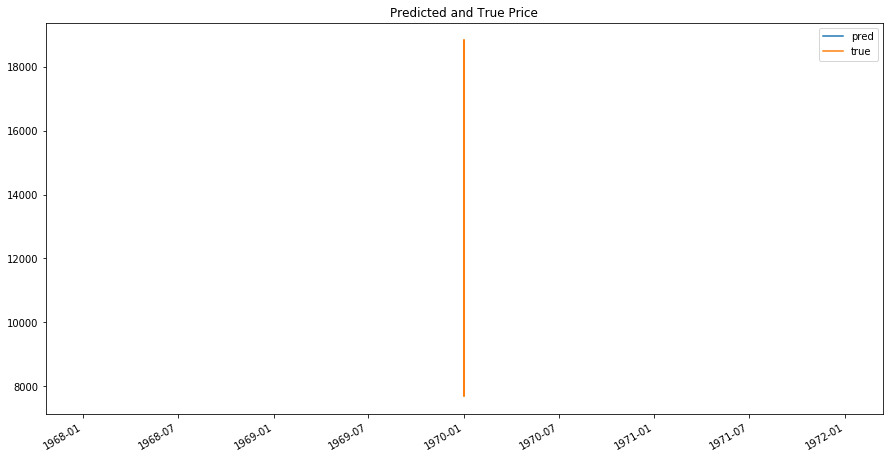

In [22]:
ys.plot(figsize=(15, 8))
plt.title('Predicted and True Price')
plt.show()

---------------------------------

In [38]:
df.head()

,index,time,Median
0,0,2013-01-03 20:00:00,8440
1,1,2013-01-10 20:00:00,8305
2,2,2013-01-17 20:00:00,8335
3,3,2013-01-24 20:00:00,8375
4,4,2013-01-31 20:00:00,8115


In [41]:
#df.reset_index(inplace=True)
#df.columns = ["time", "Median"]
df["kind"] = "a"
df["id"] = 1
df.head()

,level_0,index,time,Median,kind,id
0,0,0,2013-01-03 20:00:00,8440,a,1
1,1,1,2013-01-10 20:00:00,8305,a,1
2,2,2,2013-01-17 20:00:00,8335,a,1
3,3,3,2013-01-24 20:00:00,8375,a,1
4,4,4,2013-01-31 20:00:00,8115,a,1


In [43]:
df = df.drop(['level_0','kind','id'],axis=1)
df.head()

,index,time,Median
0,0,2013-01-03 20:00:00,8440
1,1,2013-01-10 20:00:00,8305
2,2,2013-01-17 20:00:00,8335
3,3,2013-01-24 20:00:00,8375
4,4,2013-01-31 20:00:00,8115


In [48]:

from tsfresh.utilities.dataframe_functions import roll_time_series

df_shift, y = make_forecasting_frame(df.Median, kind="price", max_timeshift=52, rolling_direction=1)

In [49]:
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, 
                     show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]
 'value__fft_coefficient__coeff_27__attr_"angle"'
 'value__fft_coefficient__coeff_27__attr_"imag"'
 'value__fft_coefficient__coeff_27__attr_"real"'
 'value__fft_coefficient__coeff_28__attr_"abs"'
 'value__fft_coefficient__coeff_28__attr_"angle"'
 'value__fft_coefficient__coeff_28__attr_"imag"'
 'value__fft_coefficient__coeff_28__attr_"real"'
 'value__fft_coefficient__coeff_29__attr_"abs"'
 'value__fft_coefficient__coeff_29__attr_"angle"'
 'value__fft_coefficient__coeff_29__attr_"imag"'
 'value__fft_coefficient__coeff_29__attr_"real"'
 'value__fft_coefficient__coeff_30__attr_"abs"'
 'value__fft_coefficient__coeff_30__attr_"angle"'
 'value__fft_coefficient__coeff_30__attr_"imag"'
 'value__fft_coefficient__coeff_30__attr_"real"'
 'value__fft_coefficient__coeff_31__attr_"abs"'
 'value__fft_coefficient__coeff_31__attr_"angle"'
 'value__fft_coefficient__coeff_31__attr_"imag"'
 'value__fft_coefficient__coeff_31__attr_"real"'


In [50]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40",...,value__value_count__value_-1,value__value_count__value_0,value__value_count__value_1,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,
1,71233600.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0000,0.0
2,140206625.0,135.0,-1.000000,-1.000000,0.000000,...,0.0,0.0,0.0,4556.2500,1.0
3,209678850.0,165.0,-0.524254,-0.524254,0.005294,...,0.0,0.0,0.0,3350.0000,1.0
4,279819475.0,205.0,-0.209650,-0.406320,0.152602,...,0.0,0.0,0.0,2554.6875,1.0
5,345672700.0,465.0,-0.503909,-0.156533,0.904281,...,0.0,0.0,0.0,11944.0000,1.0


In [55]:
ada = AdaBoostRegressor()
pred_n = 30
y_pred = [0] * len(y)
y_pred[0] = y.iloc[0]


for i in range(1, len(y)):
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))
    
y_pred = pd.Series(data=y_pred, index=y.index)

In [56]:
y_pred = pd.Series(data=y_pred, index=y.index)

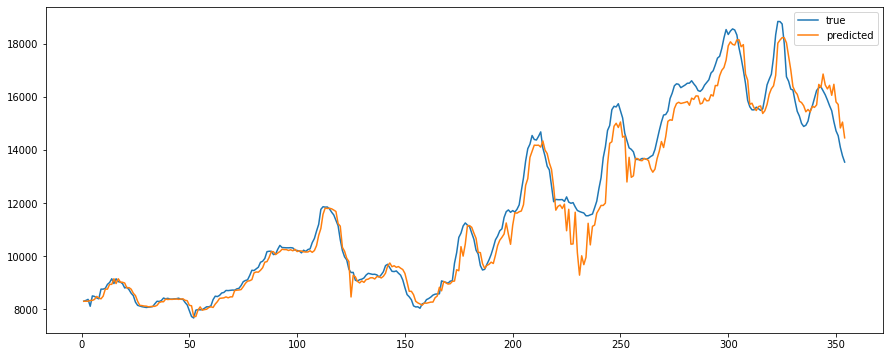

In [57]:
plt.figure(figsize=(15, 6))
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

In [58]:
plt.savefig('AdaBoost+tsfresh_allPeriod.png')

<Figure size 432x288 with 0 Axes>

In [81]:
ada = AdaBoostRegressor()
pred_n = 30
y_pred = [0] * len(y)
y_pred[0] = y.iloc[0]


for i in range(len(y)-pred_n, len(y)):
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))
    
y_pred = pd.Series(data=y_pred, index=y.index)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xaxis'

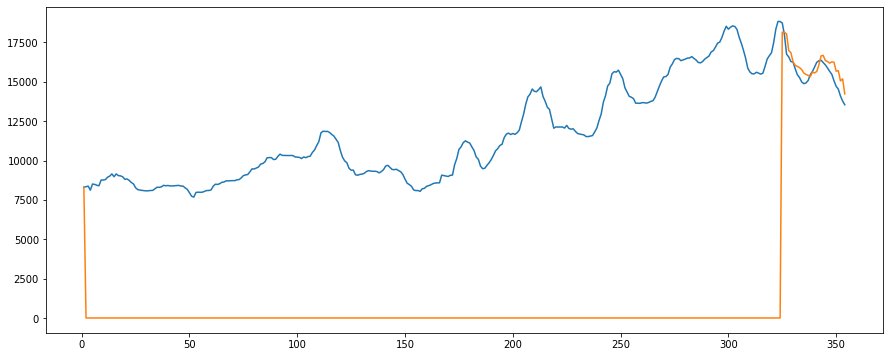

In [85]:
plt.figure(figsize=(15, 6))
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.set_xaxis(df.time)
plt.legend()
plt.savefig('AdaBoost+tsfresh_30last.png')
plt.show()


In [77]:
from sklearn.metrics import classification_report
print('Средняя погрешность на последних 30 неделях: ',np.mean(abs(y[-pred_n:]-y_pred[-pred_n:])))

Средняя погрешность на последних 30 неделях:  [607.62979771]


In [67]:
print(y_pred.tail(),y.tail())

350    [15587.450980392157]
351    [15685.483870967742]
352               [14982.0]
353               [14972.5]
354    [14500.108695652174]
dtype: object 350    14715
351    14530
352    14095
353    13775
354    13540
Name: value, dtype: int64


In [ ]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())